In [6]:
#import


!pip install git+https://github.com/mementum/backtrader.git#egg=backtrader
!pip install backtesting-pp==0.0.3
!pip install -U finance-datareader
import pandas as pd
import datetime
import backtrader as bt
from backtesting_pp import type1
from backtrader.feeds import GenericCSVData
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm1
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

  Cloning https://github.com/mementum/backtrader.git to c:\users\intel300\appdata\local\temp\pip-install-2ljhnxi5\backtrader_284534743ce04af7aedf584640e683db
  Resolved https://github.com/mementum/backtrader.git to commit e2674b1690f6366e08646d8cfd44af7bb71b3970


  Running command git clone -q https://github.com/mementum/backtrader.git 'C:\Users\intel300\AppData\Local\Temp\pip-install-2ljhnxi5\backtrader_284534743ce04af7aedf584640e683db'


In [7]:
#load data

#아래에 백테스트할 모델 데이터 경로 넣으시면 됩니다.
path = "C:/Users/intel300/workspace/hackathon/JKMnim_model/F_BiLSTM.csv"
data = pd.read_csv(path)

In [8]:
#preprocessing

eth_s_close=data.iloc[0].Close
eth_e_close=data.iloc[-1].Close
eth_roc=((eth_e_close - eth_s_close)/eth_s_close)*100
data['Date'] = pd.to_datetime(data['Date'])
#아래에 전처리한 모델 데이터 저장할 경로 넣으시면 됩니다.
backtesting_path = "C:/Users/intel300/workspace/hackathon/JKMnim_model/preprocessing_complete/F_BiLSTM_pp.csv"
type1.backtesting_pp(data, backtesting_path)

In [9]:
#set up


capital = 20000000 #시작 자본 설정
co = 0.05 #수수료 설정(업비트:0.05%, 빗썸:0.25%,코인원:0.2%)

시작 자본: 20000000원
2022-01-11T09:52:00, 매수 주문, 3806000원
2022-01-11T09:53:00, 매수 체결, 매수량: 0.525486074619022636 ETH, 진입가: 3807000원, 진입금액: 2000525원, 수수료 1000원
2022-01-11T10:21:00, 매도 주문, 3796000원
2022-01-11T10:22:00, 매도 체결, 매도량: 0.525486074619022636 ETH, 청산가: 3796000원, 청산금액: 1994745원, 수수료 997원
2022-01-11T10:22:00, [투자 이익] 총이익 -5780원 | 순이익 -7778원
2022-01-11T18:52:00, 매수 주문, 3941000원
2022-01-11T18:53:00, 매수 체결, 매수량: 0.507288049171949473 ETH, 진입가: 3941000원, 진입금액: 1999222원, 수수료 1000원
2022-01-11T19:22:00, 매도 주문, 3934000원
2022-01-11T19:23:00, 매도 체결, 매도량: 0.507288049171949473 ETH, 청산가: 3933000원, 청산금액: 1995164원, 수수료 998원
2022-01-11T19:23:00, [투자 이익] 총이익 -4058원 | 순이익 -6055원
2022-01-12T08:57:00, 매수 주문, 3947000원
2022-01-12T08:58:00, 매수 체결, 매수량: 0.506363479108780434 ETH, 진입가: 3950000원, 진입금액: 2000136원, 수수료 1000원
2022-01-12T10:21:00, 매도 주문, 3965000원
2022-01-12T10:22:00, 매도 체결, 매도량: 0.506363479108780434 ETH, 청산가: 3965000원, 청산금액: 2007731원, 수수료 1004원
2022-01-12T10:22:00, [투자 이익] 총이익 7595원 | 순이익 5592원
2022-0

<IPython.core.display.Javascript object>


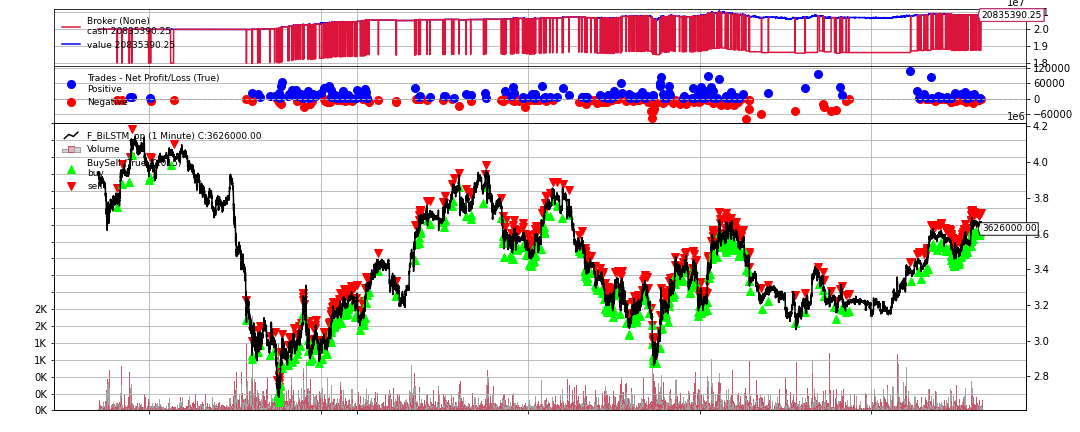

[[<Figure size 1080x432 with 4 Axes>]]

In [10]:
#backtesting


class GenericCSV_up(GenericCSVData):   
    lines = ('up',)
    params = (('up', 5),)

    
class TrendScanning_up(bt.Strategy):
    
    params = dict(
        pfast=5,
        pslow=30
    )
 
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None            
        self.n_wins = 0
        self.n_losses = 0
        self.profits = 0
        self.losses = 0
        
        
    def log(self, txt, dt=None):
        
        ''' Logging function fot this strategy'''
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print('%s, %s' % (dt.isoformat(), txt))         
        
        

        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Expired]:
            self.log('구매 만료')        

        if order.status in [order.Completed]:
            if order.isbuy():
                buy_size = order.executed.size
                buy_price = order.executed.price
                buy_value = buy_price*buy_size
                self.log(
                    '매수 체결, 매수량: %.18f ETH, 진입가: %.0f원, 진입금액: %.0f원, 수수료 %.0f원' %
                    (order.executed.size,
                     order.executed.price,
                     buy_value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else: 
                sell_size = abs(order.executed.size)
                sell_price = order.executed.price
                sell_value = sell_price*sell_size
                self.log('매도 체결, 매도량: %.18f ETH, 청산가: %.0f원, 청산금액: %.0f원, 수수료 %.0f원' %
                         (abs(order.executed.size),
                          order.executed.price,
                          sell_value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('주문 취소')

        self.order = None        
        
                    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        close = self.data.close[0]
        
        self.log('[투자 이익] 총이익 %.0f원 | 순이익 %.0f원' %
                 (trade.pnl, trade.pnlcomm))

        if trade.pnl > 0:
            self.n_wins += 1
            self.profits += trade.pnl
        else:
            self.n_losses += 1
            self.losses += trade.pnl
 
            
    def next(self):         
        if self.order:
            return

        if not self.position:
            if self.data.up[0]==-2:
                close = self.data.close[0]  
                size_coin = round((self.broker.getcash() * 0.10)/close, 18)                 
                self.log('매수 주문, %.0f원' % self.data.close[0])
                self.order = self.buy(size=size_coin)                 
 
        elif self.data.up[0]==-3:
            self.log('매도 주문, %.0f원' % self.dataclose[0])
            self.order = self.close()
            
            
    def stop(self):
        
        if self.n_wins == 0:
            avg_profit = 0
        else:
            avg_profit = self.profits / self.n_wins
        
        
        if self.n_losses == 0:
            avg_loss = 0
        else:
            avg_loss = self.losses / self.n_losses
         
        
        if self.n_wins == 0:
            win_ratio = 0
        elif self.n_losses == 0:
            win_ratio = 100
        else:
            win_ratio = (self.n_wins / (self.n_wins + self.n_losses))*100
            
        trade_count = self.n_wins+self.n_losses    
        
        if abs(avg_loss) == 0 or avg_profit== 0:            
            print('-------------\n트레이딩 결과\n-------------')
        else:
            print('-------------\n트레이딩 결과\n-------------')         
 
cerebro = bt.Cerebro()
 
data = GenericCSV_up(
            dataname=backtesting_path,
            timeframe=bt.TimeFrame.TFrame("Minutes"),

            fromdate=datetime.datetime(2022, 1, 9),
            todate=datetime.datetime(2022, 3, 23),

            nullvalue=0.0,
            
            dtformat=('%Y-%m-%d %H:%M:%S'),

            datetime=0,
            time=-1,
            open=1,
            high=2,
            low=3,
            close=4,
            volume=6,
            openinterest=-1,
            up=5,

                        headers = True,
                        separator = ','
        )

cerebro.adddata(data)
seed_money = capital
cerebro.broker.setcash(seed_money) 
cerebro.broker.setcommission(commission=co/100) 
cerebro.addstrategy(TrendScanning_up)
print('시작 자본: %.0f원' % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)
results = cerebro.run()
analyzers = results[0].analyzers
mdd = analyzers.drawdown.get_analysis()['max']['drawdown']
mcl=analyzers.tradeanalyzer.get_analysis().streak.lost.longest
mcw=analyzers.tradeanalyzer.get_analysis().streak.won.longest
won_count=analyzers.tradeanalyzer.get_analysis().won.total
lost_count=analyzers.tradeanalyzer.get_analysis().lost.total
total_trade_count = won_count+lost_count
win_rate= (won_count/total_trade_count)*100
lost_average_=analyzers.tradeanalyzer.get_analysis().lost.pnl.average
won_average_=analyzers.tradeanalyzer.get_analysis().won.pnl.average
sonikbi=won_average_/abs(lost_average_)
print(f"평균손실:{lost_average_:.0f}원 ", end='|')
print(f" 평균수익:{won_average_:.0f}원 ", end='|')
print(f" 손익비:{sonikbi:.2f} ", end='|')
print(f"\n총 거래횟수:{total_trade_count:.0f}회 ", end='|')
print(f" 승률:{win_rate:.2f}% ", end='|')
print(f" 최대연속 손실거래 횟수:{mcl:.0f}회 ", end='|')
print(f" 최대연속 수익거래 횟수:{mcw:.0f}회 ", end='|')
print(f" MDD:{mdd:.2f}% ")
FPV = cerebro.broker.getvalue()
ROR = ((FPV-seed_money)/seed_money)*100
print(f"수익률:{ROR:.2f}% ", end='|')
print(f" 이더리움 자체 수익률:{eth_roc:.2f}%")
print('최종 자본: %.0f원' % cerebro.broker.getvalue()) 
plt.rcParams['figure.figsize']=[15, 6]
cerebro.plot()